# Graph classification

This is a comment

## Imports

In [1336]:
!pip install matplotlib

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels

## Global variables

In [2]:
nr_examples_train = 14
nr_examples_test = 4
nr_trials = 5
nr_states_per_example = 3
embeddings_folders = ["sum_weight_10, sum_weight_20, sum_weight_30, sum_weight_40, sum_weight_50",
                     "sum_weight_60", "sum_weight_70", "sum_weight_80","sum_weight_90","sum_weight_100"]

embedding_folder = "sum_weight_100"
dataset_folder = "./embedding_high"

results_file_overall_accuracy = "overall_accuracy_high.txt"
results_file_control = "control_high.txt"
results_file_etoh = "etoh_high.txt"
results_file_naltrexone = "naltrexone_high.txt"
results_file_abstinence = "abstinence_high.txt"

classes = ["Control","EtOH", "Naltrexone", "Abstinence"]

nr_examples_train_total = nr_trials * nr_examples_train * nr_states_per_example
nr_examples_test_total = nr_trials * nr_examples_test * nr_states_per_example

nr_nodes = 85
encode_dim = 8

## Utils functions

In [3]:
def make_array(nr_rows, nr_nodes, nr_dims):
    if nr_rows:
        dataset = np.ndarray((nr_rows, nr_nodes, nr_dims), dtype=np.float32)
        labels = np.ndarray(nr_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [4]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [5]:
def create_labels(state):
    switcher = {
        "Control" : 0,
        "EtOH" : 1,
        "Naltrexone" : 2,
        "Abstinence" : 3
    }
    
    return switcher.get(state, lambda:"Invalid state")

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes, name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # print(unique_labels(y_true, y_pred))
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    # plt.savefig(name)
    return cm, ax

## Reading data

In [7]:
dataset_embeddings_train, labels_embeddings_train = make_array(nr_examples_train_total, nr_nodes, encode_dim)
dataset_embeddings_test, labels_embeddings_test = make_array(nr_examples_test_total, nr_nodes, encode_dim)

In [8]:
index_train = 0
index_test = 0
path_to_read = os.path.join(dataset_folder, embedding_folder)
for filename in sorted(os.listdir(path_to_read)):
    path_to_read_embedding = os.path.join(path_to_read, filename)
    embedding = np.loadtxt(path_to_read_embedding, delimiter=",")
    nr_example, state, _ = filename.split("-")
    if int(nr_example) <= nr_examples_train:
        dataset_embeddings_train[index_train,:,:] = embedding
        labels_embeddings_train[index_train] = create_labels(state)
#         dataset_embeddings_train = np.vstack([dataset_embeddings_train, embedding])
#         labels_embeddings_train = np.vstack([labels_embeddings_train, create_labels(state)])
        index_train += 1
    else:
        dataset_embeddings_test[index_test,:,:] = embedding
        labels_embeddings_test[index_test] = create_labels(state)
        index_test += 1

In [9]:
labels_embeddings_test.shape

(60,)

In [10]:
labels_embeddings_train.shape

(210,)

## Training part

In [11]:
final_dataset_train, final_labels_train = randomize(dataset_embeddings_train, labels_embeddings_train)
final_dataset_test, final_labels_test = randomize(dataset_embeddings_test, labels_embeddings_test)

In [12]:
nsamples, nx, ny = final_dataset_train.shape
d2_train_dataset = final_dataset_train.reshape((nsamples, nx*ny))

nsamples, nx, ny = final_dataset_test.shape
d2_test_dataset = final_dataset_test.reshape((nsamples, nx*ny))

### LinearSVC

In [13]:
df_pipeline_LinearSVC = Pipeline([("estimator", LinearSVC())])

param_grid = [
  {'estimator__C': [0.1, 1, 10, 100, 1000,10000], 'estimator__class_weight' : ['balanced',None],\
   'estimator__loss' : ['hinge','squared_hinge']}
 ]

gs_lsvc = GridSearchCV(df_pipeline_LinearSVC, param_grid, scoring="accuracy", cv=10)

gs_lsvc.fit(d2_train_dataset, final_labels_train)

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('estimator', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'estimator__C': [0.1, 1, 10, 100, 1000, 10000], 'estimator__class_weight': ['balanced', None], 'estimator__loss': ['hinge', 'squared_hinge']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [14]:
gs_lsvc.best_params_

{'estimator__C': 0.1,
 'estimator__class_weight': 'balanced',
 'estimator__loss': 'squared_hinge'}

In [15]:
gs_lsvc.best_score_

0.3952380952380952

In [16]:
f_accuracy = open(results_file_overall_accuracy,"a+")

In [17]:
f_accuracy.write("\n" + str(gs_lsvc.best_score_))

19

In [18]:
df_pipeline_LinearSVC.set_params(**gs_lsvc.best_params_)
df_pipeline_LinearSVC.fit(d2_train_dataset,final_labels_train)

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('estimator', LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [19]:
final_labels_train_predict = cross_val_predict(df_pipeline_LinearSVC, d2_train_dataset, final_labels_train, cv=6)

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

In [20]:
name_cm = embedding_folder + "_svm_train.png"

Confusion matrix, without normalization
[[35 24  6  5]
 [28 20 13  9]
 [ 8 12  8  7]
 [ 8 10  5 12]]


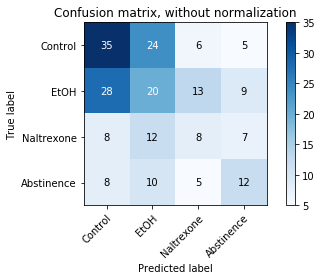

In [21]:
# Plot non-normalized confusion matrix
cm, _ = plot_confusion_matrix(final_labels_train, final_labels_train_predict, classes=classes, name = name_cm,
                      title='Confusion matrix, without normalization')

In [22]:
name_cm = embedding_folder + "_svm_train_normalized.png"

Normalized confusion matrix
[[0.5        0.34285714 0.08571429 0.07142857]
 [0.4        0.28571429 0.18571429 0.12857143]
 [0.22857143 0.34285714 0.22857143 0.2       ]
 [0.22857143 0.28571429 0.14285714 0.34285714]]


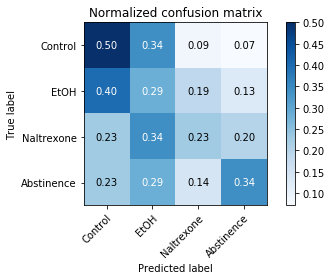

In [23]:
# Plot normalized confusion matrix
norm_cm, _ = plot_confusion_matrix(final_labels_train, final_labels_train_predict, classes=classes, normalize=True, name=name_cm,
                      title='Normalized confusion matrix')

In [24]:
f_control = open(results_file_control,"a+")
f_etoh = open(results_file_etoh,"a+")
f_naltrexone = open(results_file_naltrexone,"a+")
f_abstinence = open(results_file_abstinence,"a+")

In [25]:
f_control.write("\n" + str(norm_cm[0][0]))
f_etoh.write("\n" + str(norm_cm[1][1]))
f_naltrexone.write("\n" + str(norm_cm[2][2]))
f_abstinence.write("\n" + str(norm_cm[3][3]))

20

### Random Forest

In [1362]:
df_pipeline_RF = Pipeline([
    ("estimator", RandomForestClassifier())
])

param_grid = {"estimator__n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],\
              "estimator__max_depth" : [2, 3, 4, 5],"estimator__criterion" : ['entropy','gini']}

gs_RF = GridSearchCV(df_pipeline_RF, param_grid, scoring="accuracy", cv=10)

gs_RF.fit(d2_train_dataset, final_labels_train)

/home/ldp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('estimator', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'estimator__max_depth': [2, 3, 4, 5], 'estimator__criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [1363]:
gs_RF.best_params_

{'estimator__criterion': 'entropy',
 'estimator__max_depth': 2,
 'estimator__n_estimators': 50}

In [1364]:
gs_RF.best_score_

0.4238095238095238

In [1365]:
f_accuracy.write("\n" + str(gs_RF.best_score_))

19

In [1366]:
df_pipeline_RF.set_params(**gs_RF.best_params_)
df_pipeline_RF.fit(d2_train_dataset,final_labels_train)

Pipeline(memory=None,
     steps=[('estimator', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [1367]:
final_labels_train_predict = cross_val_predict(df_pipeline_RF, d2_train_dataset, final_labels_train, cv=6)

In [1368]:
name_cm = embedding_folder + "_rf_train.png"

Confusion matrix, without normalization
[[34 35  1  0]
 [25 41  3  1]
 [ 8 25  1  1]
 [ 9 23  3  0]]


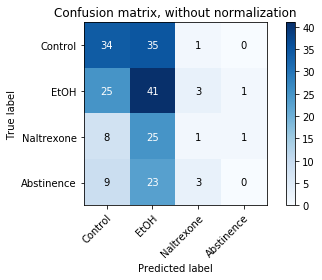

In [1369]:
# Plot non-normalized confusion matrix
cm, _ = plot_confusion_matrix(final_labels_train, final_labels_train_predict, classes=classes, name = name_cm,
                      title='Confusion matrix, without normalization')

In [1370]:
name_cm = embedding_folder + "_rf_train_normalized.png"

Normalized confusion matrix
[[0.49 0.5  0.01 0.  ]
 [0.36 0.59 0.04 0.01]
 [0.23 0.71 0.03 0.03]
 [0.26 0.66 0.09 0.  ]]


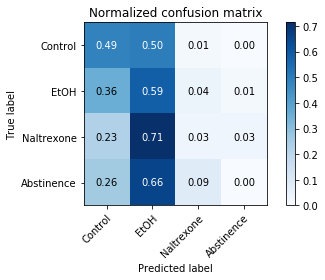

In [1371]:
# Plot normalized confusion matrix
norm_cm, _ = plot_confusion_matrix(final_labels_train, final_labels_train_predict, classes=classes, normalize=True, 
                                   name=name_cm, title='Normalized confusion matrix')

In [1372]:
f_control.write("\n" + str(norm_cm[0][0]))
f_etoh.write("\n" + str(norm_cm[1][1]))
f_naltrexone.write("\n" + str(norm_cm[2][2]))
f_abstinence.write("\n" + str(norm_cm[3][3]))

4

## Test part

### LinearSVC

In [1373]:
predictions_LinearSVC = df_pipeline_LinearSVC.predict(d2_test_dataset)

In [1374]:
test_score_svm = accuracy_score(final_labels_test, predictions_LinearSVC)
test_score_svm

0.36666666666666664

In [1375]:
f_accuracy.write("\n" + str(test_score_svm))

20

In [1376]:
name_cm = embedding_folder + "_svm_test.png"

Confusion matrix, without normalization
[[11  3  5  1]
 [ 4  7  7  2]
 [ 2  4  3  1]
 [ 5  2  2  1]]


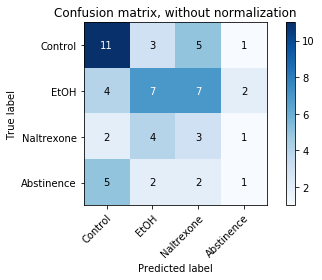

In [1377]:
# Plot non-normalized confusion matrix
cm, _ = plot_confusion_matrix(final_labels_test, predictions_LinearSVC, classes=classes, name = name_cm,
                      title='Confusion matrix, without normalization')

In [1378]:
name_cm = embedding_folder + "_svm_test_normalized.png"

Normalized confusion matrix
[[0.55 0.15 0.25 0.05]
 [0.2  0.35 0.35 0.1 ]
 [0.2  0.4  0.3  0.1 ]
 [0.5  0.2  0.2  0.1 ]]


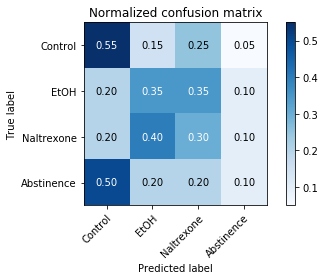

In [1379]:
# Plot normalized confusion matrix
norm_cm, _ = plot_confusion_matrix(final_labels_test, predictions_LinearSVC, classes=classes, normalize=True, 
                                   name=name_cm, title='Normalized confusion matrix')

In [1380]:
f_control.write("\n" + str(norm_cm[0][0]))
f_etoh.write("\n" + str(norm_cm[1][1]))
f_naltrexone.write("\n" + str(norm_cm[2][2]))
f_abstinence.write("\n" + str(norm_cm[3][3]))

4

### Random Forest

In [1381]:
predictions_RF = df_pipeline_RF.predict(d2_test_dataset)

In [1382]:
test_score_rf = accuracy_score(final_labels_test, predictions_RF)
test_score_rf

0.4166666666666667

In [1383]:
f_accuracy.write("\n" + str(test_score_rf))

19

In [1384]:
name_cm = embedding_folder + "_rf_test.png"

Confusion matrix, without normalization
[[12  7  1  0]
 [ 7 12  1  0]
 [ 0  9  1  0]
 [ 4  6  0  0]]


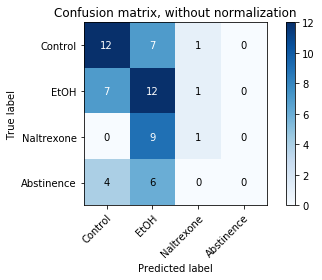

In [1385]:
# Plot non-normalized confusion matrix
cm, _ = plot_confusion_matrix(final_labels_test, predictions_RF, classes=classes, name = name_cm,
                      title='Confusion matrix, without normalization')

In [1386]:
name_cm = embedding_folder + "_rf_test_normalized.png"

Normalized confusion matrix
[[0.6  0.35 0.05 0.  ]
 [0.35 0.6  0.05 0.  ]
 [0.   0.9  0.1  0.  ]
 [0.4  0.6  0.   0.  ]]


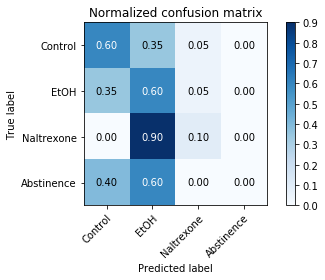

In [1387]:
# Plot normalized confusion matrix
norm_cm, _ = plot_confusion_matrix(final_labels_test, predictions_RF, classes=classes, normalize=True, 
                                   name=name_cm, title='Normalized confusion matrix')

In [1388]:
f_control.write("\n" + str(norm_cm[0][0]))
f_etoh.write("\n" + str(norm_cm[1][1]))
f_naltrexone.write("\n" + str(norm_cm[2][2]))
f_abstinence.write("\n" + str(norm_cm[3][3]))

4

In [1389]:
f_control.close()
f_etoh.close()
f_naltrexone.close()
f_abstinence.close()
f_accuracy.close()

## Results

## Conclusions